In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import tqdm
#import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_moons
from torchvision import datasets, transforms

## Define basic Autoencoder class and necessary routines

In [2]:
# autoencoder skeleton

class Autoencoder(nn.Module):
    def __init__(self, input_size, num_hidden_layers, hidden_layer_size, bottleneck_size):
        super(Autoencoder, self).__init__()

        # define architecture of the autoencoder
        self.input_size = input_size
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layer_size = hidden_layer_size
        self.bottleneck_size = bottleneck_size

        # construct the encoder and decoder
        self.encoder = self.construct_encoder()
        self.decoder = self.construct_decoder()

        # define loss function and optimizer
        self.loss = nn.MSELoss(reduction='mean')
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        
    def construct_encoder(self):
        # construct the encoder
        encoder = nn.Sequential()

        encoder.add_module('input', nn.Linear(self.input_size, self.hidden_layer_size))
        encoder.add_module('relu_input', nn.ReLU())

        for i in range(self.num_hidden_layers - 1):
            encoder.add_module('hidden_' + str(i), nn.Linear(self.hidden_layer_size, self.hidden_layer_size))
            encoder.add_module('relu_' + str(i), nn.ReLU())

        encoder.add_module('bottleneck', nn.Linear(self.hidden_layer_size, self.bottleneck_size))

        return encoder
    
    def construct_decoder(self):
        # construct the decoder
        decoder = nn.Sequential()

        decoder.add_module('input', nn.Linear(self.bottleneck_size, self.hidden_layer_size))
        decoder.add_module('relu_input', nn.ReLU())

        for i in range(self.num_hidden_layers - 1):
            decoder.add_module('hidden_' + str(i), nn.Linear(self.hidden_layer_size, self.hidden_layer_size))
            decoder.add_module('relu_' + str(i), nn.ReLU())

        decoder.add_module('output', nn.Linear(self.hidden_layer_size, self.input_size))

        return decoder
    
    def forward(self, x):
        # forward pass
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [3]:
# define training loop

def train_autoencoder(model, X_train, X_val, n_epochs=10, batch_size=32, verbose=True):
    loss_history = {
        'train': [],
        'val': []
    }
    
    if verbose:
        pbar = tqdm.tqdm(range(n_epochs))
    else:
        pbar = range(n_epochs)

    for epoch in pbar:
        # training
        model.train()
        train_loss = 0
        for i in tqdm.tqdm(range(0, X_train.shape[0], batch_size)):
            batch = X_train[i:i+batch_size]
            model.optimizer.zero_grad()
            output = model(batch)
            loss = model.loss(output, batch)
            loss.backward()
            model.optimizer.step()
            train_loss += loss.item()
        train_loss /= X_train.shape[0]
        loss_history['train'].append(train_loss)

        # validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for i in range(0, X_val.shape[0], batch_size):
                batch = X_val[i:i+batch_size]
                output = model(batch)
                loss = model.loss(output, batch)
                val_loss += loss.item()
        val_loss /= X_val.shape[0]
        loss_history['val'].append(val_loss)

        # print loss
        if verbose:
            pbar.set_description('Epoch: {}/{}, train loss: {:.4f}, val loss: {:.4f}'.format(epoch+1, n_epochs, train_loss, val_loss))
            
    return loss_history

In [4]:
# define function to plot loss history

def plot_loss_history(loss_history):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    epochs_linspace = np.linspace(1, len(loss_history['train']), len(loss_history['train']))

    ax.scatter(epochs_linspace, loss_history['train'], label='train loss', marker='o')
    ax.scatter(epochs_linspace, loss_history['val'], label='val loss', marker='x')

    ax.plot(epochs_linspace, loss_history['train'])
    ax.plot(epochs_linspace, loss_history['val'])

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

    ax.set_yscale('log')

    ax.grid(alpha=0.35)
    ax.legend()

## Use the autoencoder for a 2D dataset

In [34]:
# architecture of a basic autoencoder

INPUT_SIZE = 2
BOTTLENECK_SIZE = 1
HIDDEN_SIZE = 64
HIDDEN_LAYERS = 5

autoencoder_moons = Autoencoder(INPUT_SIZE, HIDDEN_LAYERS, HIDDEN_SIZE, BOTTLENECK_SIZE)

In [40]:
# load data

dataset_size = 5000

dataset = make_moons(n_samples=dataset_size, noise=0.1)[0]

# split data into train and validation sets

X_train, X_val = train_test_split(dataset, test_size=0.2)

X_val, X_test = train_test_split(X_val, test_size=0.5)


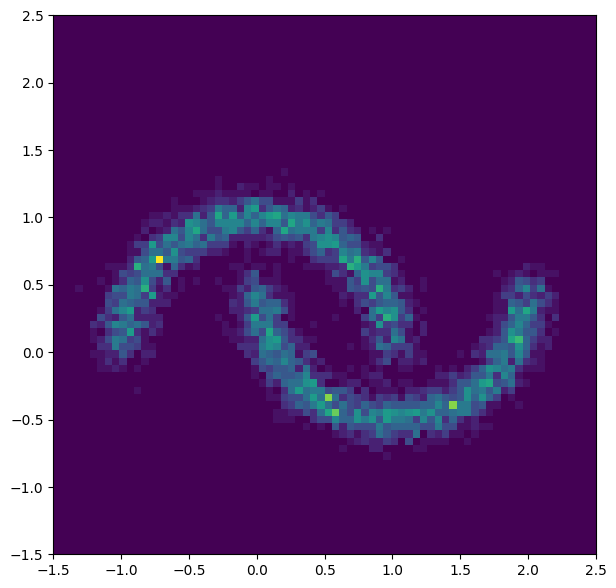

In [21]:
# visualise data as density plot

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.hist2d(dataset[:, 0], dataset[:, 1], bins=np.linspace(-1.5, 2.5, 75));


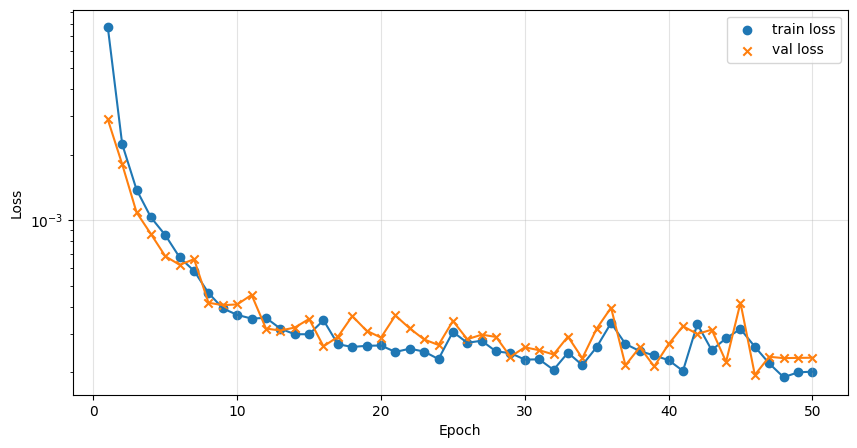

In [39]:
# train autoencoder on the moon dataset

loss_history_moons = train_autoencoder(autoencoder_moons, torch.Tensor(X_train), torch.Tensor(X_val), n_epochs=50, batch_size=32)

# plot loss history

plot_loss_history(loss_history_moons)

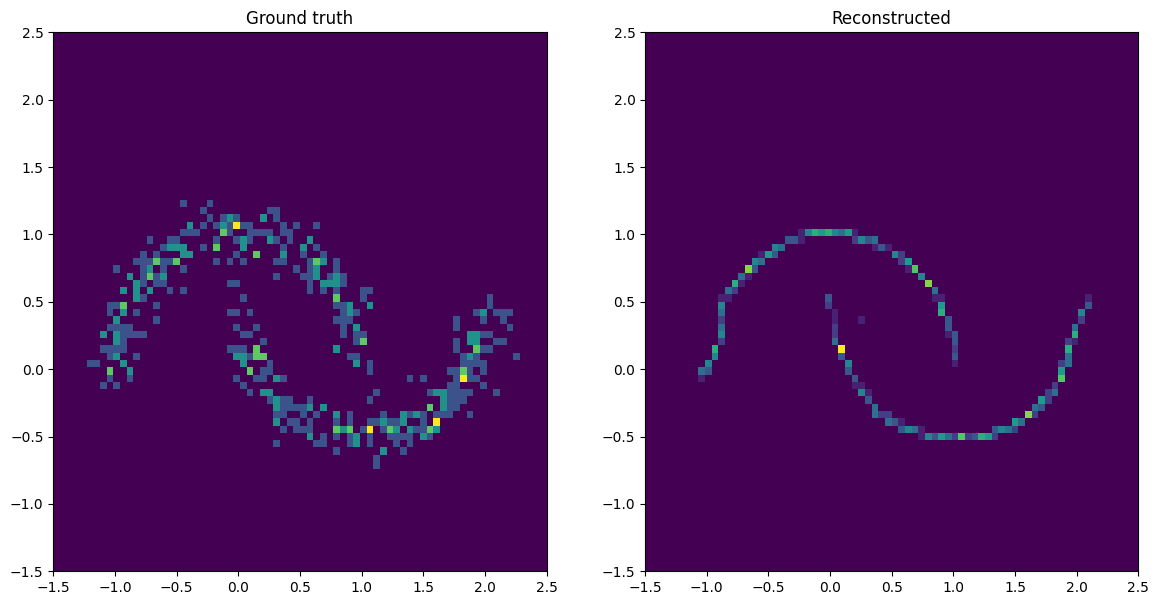

In [43]:
# compare ground thruth and reconstructed data of test set

reconstructed_moons = autoencoder_moons(torch.Tensor(X_test)).detach().numpy()

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

ax[0].hist2d(X_test[:, 0], X_test[:, 1], bins=np.linspace(-1.5, 2.5, 75))
ax[0].set_title('Ground truth')

ax[1].hist2d(reconstructed_moons[:, 0], reconstructed_moons[:, 1], bins=np.linspace(-1.5, 2.5, 75))
ax[1].set_title('Reconstructed');

## More complex example: MNIST

In [52]:
# define convolutional autoencoder

class ConvAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_hidden_layers, bottleneck_size):
        super(ConvAutoencoder, self).__init__()

        # define architecture of the autoencoder
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.num_hidden_layers = num_hidden_layers
        self.bottleneck_size = bottleneck_size

        self.mnist_size = 28

        # construct the encoder and decoder
        self.encoder = self.construct_encoder()
        self.decoder = self.construct_decoder()

        # define loss function and optimizer
        self.loss = nn.MSELoss(reduction='mean')
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)

    def construct_encoder(self):
        # construct the encoder
        encoder = nn.Sequential()

        encoder.add_module('input', nn.Conv2d(self.input_size, self.hidden_layer_size, kernel_size=3, stride=1, padding=1))
        encoder.add_module('relu_input', nn.ReLU())

        for i in range(self.num_hidden_layers - 1):
            encoder.add_module('hidden_' + str(i), nn.Conv2d(self.hidden_layer_size, self.hidden_layer_size, kernel_size=3, stride=1, padding=1))
            encoder.add_module('relu_' + str(i), nn.ReLU())

        # dense bottleneck layer
        encoder.add_module('flatten', nn.Flatten())
        encoder.add_module('bottleneck', nn.Linear(self.hidden_layer_size * self.mnist_size *self.mnist_size, self.bottleneck_size))

        return encoder
    
    def construct_decoder(self):
        # construct the decoder
        decoder = nn.Sequential()

        decoder.add_module('input', nn.Linear(self.bottleneck_size, self.hidden_layer_size * self.mnist_size * self.mnist_size))
        decoder.add_module('reshape', nn.Unflatten(1, (self.hidden_layer_size, self.mnist_size, self.mnist_size)))
        decoder.add_module('relu_input', nn.ReLU())

        for i in range(self.num_hidden_layers - 1):
            decoder.add_module('hidden_' + str(i), nn.Conv2d(self.hidden_layer_size, self.hidden_layer_size, kernel_size=3, stride=1, padding=1))
            decoder.add_module('relu_' + str(i), nn.ReLU())

        decoder.add_module('output', nn.Conv2d(self.hidden_layer_size, self.input_size, kernel_size=3, stride=1, padding=1))

        return decoder
    
    def forward(self, x):
        # forward pass
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

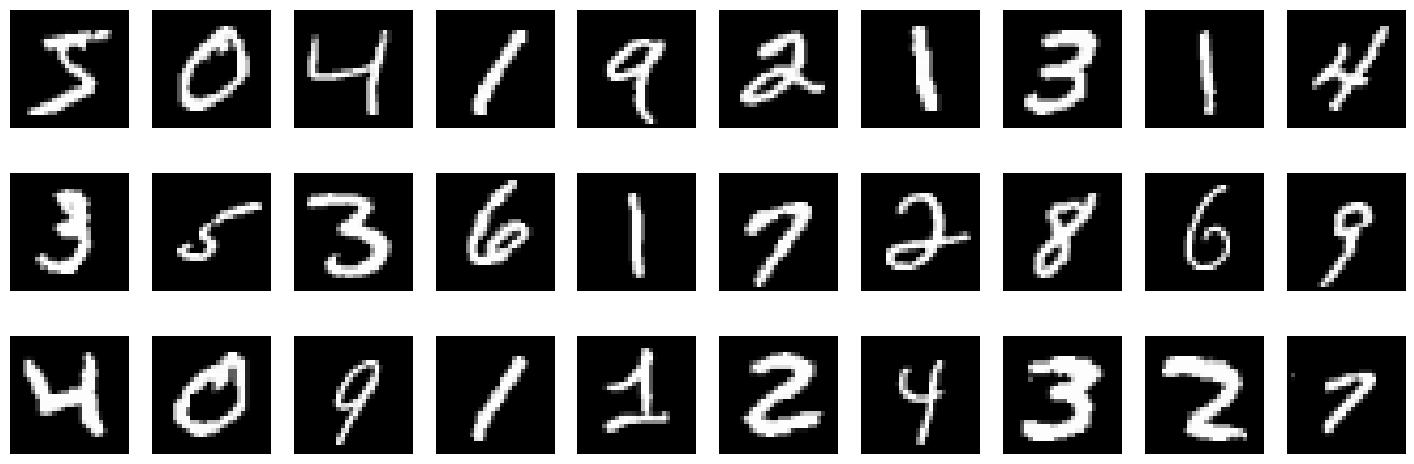

In [53]:
# get MNIST dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

mnist_test_data, mnist_val_data = train_test_split(mnist_test_data, test_size=0.5)

mnist_train = torch.stack([x for x, _ in mnist_train_data])
mnist_test = torch.stack([x for x, _ in mnist_test_data])
mnist_val = torch.stack([x for x, _ in mnist_val_data])

mnist_test_labels = torch.Tensor([y for _, y in mnist_test_data])

# visualise data

fig, ax = plt.subplots(3, 10, figsize=(18, 6))

for i in range(3):
    for j in range(10):
        ax[i, j].imshow(mnist_train[i*10 + j].squeeze(), cmap='gray')
        ax[i, j].axis('off')


In [110]:
# train autoencoder on MNIST dataset

INPUT_SIZE = 1
BOTTLENECK_SIZE = 2
HIDDEN_SIZE = 2
HIDDEN_LAYERS = 2

conv_autoencoder_mnist = ConvAutoencoder(INPUT_SIZE, HIDDEN_SIZE, HIDDEN_LAYERS, BOTTLENECK_SIZE)

loss_history_mnist = train_autoencoder(conv_autoencoder_mnist, mnist_train, mnist_val, n_epochs=10, batch_size=32)

100%|██████████| 1875/1875 [00:12<00:00, 147.50it/s]90%|█████████ | 9/10 [01:56<00:12, 12.98s/it]
Epoch: 10/10, train loss: 0.0063, val loss: 0.0064: 100%|██████████| 10/10 [02:09<00:00, 12.99s/it]


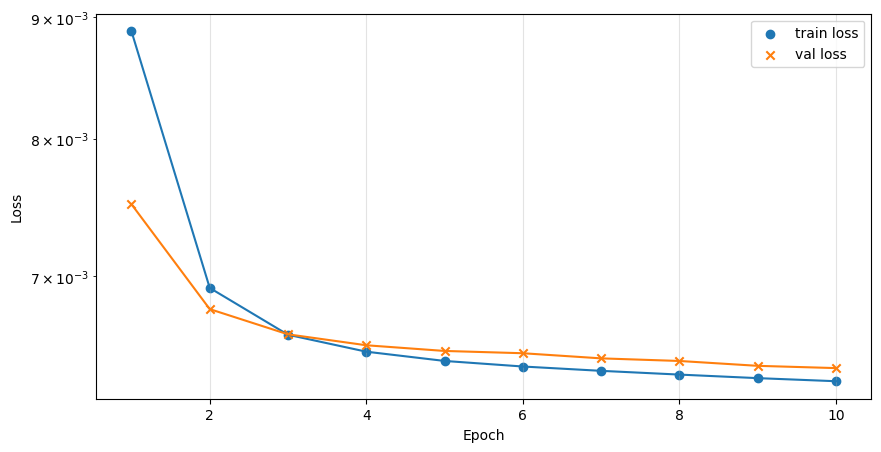

In [111]:
plot_loss_history(loss_history_mnist)

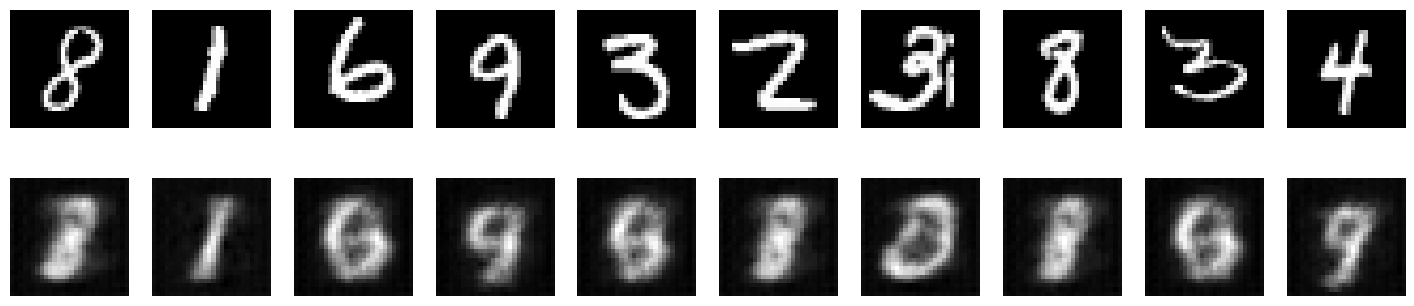

In [112]:
# look at reconstructions of test set

reconstructed_mnist = conv_autoencoder_mnist(mnist_test).detach().numpy()

# compare ground truth and reconstructed data

fig, ax = plt.subplots(2, 10, figsize=(18, 4))

for i in range(10):
    ax[0, i].imshow(mnist_test[i].squeeze(), cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(reconstructed_mnist[i].squeeze(), cmap='gray')
    ax[1, i].axis('off')


(-3.25, 3.25)

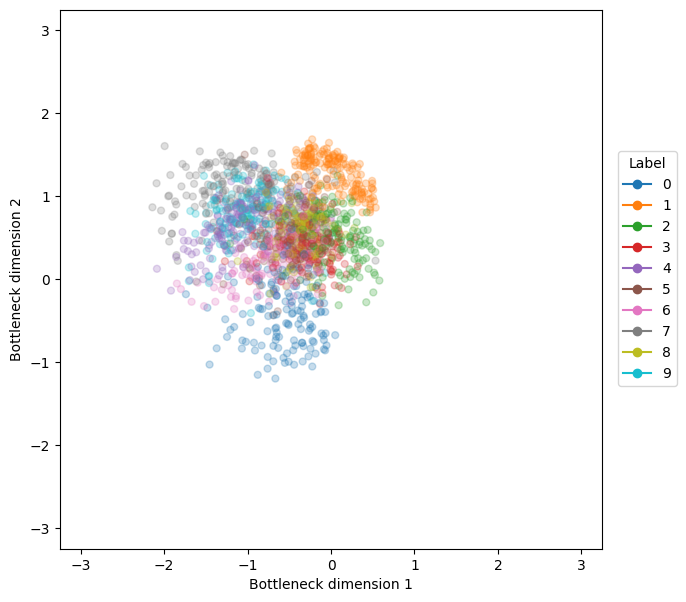

In [113]:
# visualise bottleneck layer with respect to the labels

bottleneck_mnist = conv_autoencoder_mnist.encoder(mnist_test).detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.scatter(bottleneck_mnist[:1500, 0], bottleneck_mnist[:1500, 1], c=mnist_test_labels[:1500], cmap='tab10', alpha=0.25, marker='.', s=100)

ax.set_xlabel('Bottleneck dimension 1')
ax.set_ylabel('Bottleneck dimension 2')

legend_handeles = []   
for i in range(10):
    legend_handeles.append(plt.Line2D([0], [0], marker='o', color=plt.cm.tab10.colors[i], label=str(i)))

ax.legend(handles=legend_handeles, title='Label', loc='upper right', bbox_to_anchor=(1.15, 0.75));

ax.set_ylim(-3.25, 3.25)
ax.set_xlim(-3.25, 3.25)

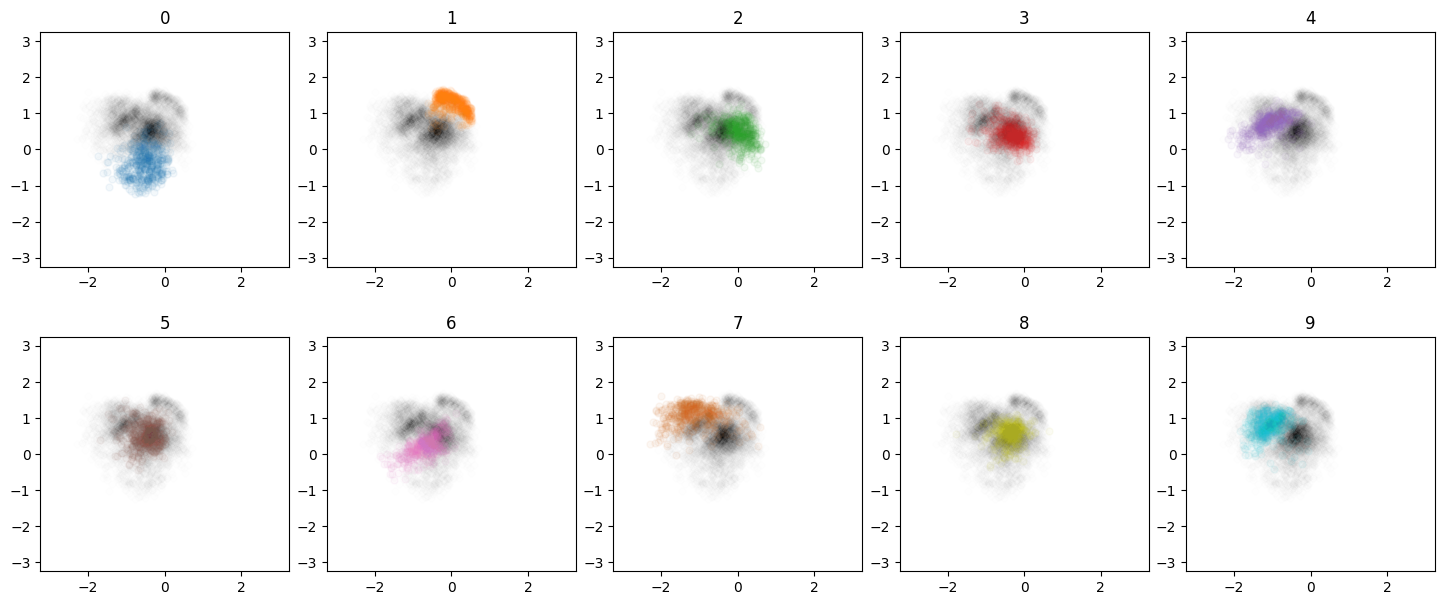

In [116]:
# make subplots for each digit

fig, ax = plt.subplots(2, 5, figsize=(18, 7))

for i in range(10):
    for j in range(10):
        if j != i:
            ax[i//5, i%5].scatter(bottleneck_mnist[mnist_test_labels == j, 0], bottleneck_mnist[mnist_test_labels == j, 1], color='black', alpha=0.005, marker='.', s=100)

    if i != 7:
        ax[i//5, i%5].scatter(bottleneck_mnist[mnist_test_labels == i, 0], bottleneck_mnist[mnist_test_labels == i, 1], color=plt.cm.tab10.colors[i], alpha=0.05, marker='.', s=100)
        ax[i//5, i%5].set_title('{}'.format(i))
    else:
        ax[i//5, i%5].scatter(bottleneck_mnist[mnist_test_labels == i, 0], bottleneck_mnist[mnist_test_labels == i, 1], color='chocolate', alpha=0.05, marker='.', s=100)
        ax[i//5, i%5].set_title('{}'.format(i))

    ax[i//5, i%5].set_xlim(-3.25, 3.25)
    ax[i//5, i%5].set_ylim(-3.25, 3.25)

    fig.subplots_adjust(hspace=0.3)
    fig.subplots_adjust(wspace=0.15)
    